In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import dabest
import pathlib as plb
from scipy.stats import norm
import statistics

In [2]:
### Read in data that contains unblinded compounds, chemotaxis indeces and worm totals
### for the entire screen. 
###This will be used to grab worm location files to use for resampling.

screen_data = pd.read_csv('/Volumes/LaCie/_2021_03_screen/2103_data_unblinded.csv', index_col=0)
#screen_data.head()

In [3]:
#Creating a subset of the 2103 data using 1 control, 1 positive and 1 negative
#reference compound
test_comps = ['DMSO', 'Diacetyl', 'R(-)-Carvone']
subset =  screen_data.loc[screen_data['Compound Name'].isin(test_comps)]
#subset

In [4]:
#Generating a file path to dynamically read in worm location files
wrm_locs_fldr = plb.Path('/Volumes/LaCie/_2021_03_screen/_2021_03_automated_results/')

In [5]:
# Aggregating individual worm location .csv files for each ref/control compound to be used
# for resampling

def get_worm_locs(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound Name']
    xs = temp['centroid-1']
    #xs = list(temp['centroid-1'])
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict


In [6]:
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in subset.iterrows():
    pooled_refs = get_worm_locs(row, wrm_locs_fldr, results_dict)

#Casting dict to df
pooled_refs_df = pd.DataFrame.from_dict(pooled_refs)
print(len(pooled_refs_df))

747


In [7]:
# Creating a np array of all worm locations from 2103 dataset to be used for resampling
x_dmso = np.asarray(pooled_refs_df['DMSO'])
# Generating sample pools of varying sizes
sample_sizes = [50, 100, 150, 200, 250, 300, 350]
# Resampling each sample size 100x
n = 100

In [8]:
def calc_chemotaxis_index(worms):
    
    ## Assign features to zones of the plate
    left_area_boundary = int(4/9*3000) #Need to generate a more accurate boundary value
    #print(left_area_boundary)
    right_area_boundary = int(5/9*3000) #Need to generate a more accurate boundary value
    #print(right_area_boundary)

    left_side_worms = worms[worms['X'] <= left_area_boundary]
    #middle_w = worms[worms['centroid-1'] < right_area_boundary]
    #middle_worms = middle_w[middle_w['centroid-1'] >left_area_boundary]
    right_side_worms = worms[worms['X'] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    #worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(right_side_worms) + len(left_side_worms)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))

    

    try:
        chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
        return chemotaxis_index

    except ZeroDivisionError:
        return 0
    

In [9]:
print(x_dmso.max())
print(x_dmso.min())

2986
41


### Bootstrapping steps
1. Randomly sample 50 worms -> hold in an array
2. Calculate chemotaxis index for group of 50 worms 
3. Iterate random sampling and CI calculation 100 times -> Hold CIs in an array
4. Plot


### The following will generate a wide dataframe of the bootstrapped values

In [10]:
CI_df = pd.DataFrame(columns=sample_sizes)
for j in sample_sizes:
    CIs = []
    #for n in sample_sizes:
    i=0
    while i < 100:
        resample = np.random.choice(a=x_dmso, size=j, replace=True)
        resample_df = pd.DataFrame(resample, columns=['X'])
        CI = calc_chemotaxis_index(resample_df)
        CIs.append(CI)
        i += 1
    CI_df[j]= CIs
    #print(len(CIs))
CI_df.head()

,50,100,150,200,250,300,350
0,0.000000,0.023256,0.145038,0.114754,0.271889,0.091603,0.105431
1,0.302326,0.139535,0.053435,0.173184,-0.017699,0.019305,0.086817
2,0.111111,0.115789,0.145038,0.206522,0.074236,0.176030,0.091483
3,-0.086957,0.333333,0.218750,0.195531,0.044248,0.062271,0.175719
4,0.130435,0.162791,0.159420,0.045977,0.135135,0.240602,0.025157


### The following will generate a long dataframe

In [11]:
CI_df_long = pd.DataFrame(columns=['CI', 'N'])
for j in sample_sizes:
    CIs = []
    #for n in sample_sizes:
    i=0
    while i < 100:
        resample = np.random.choice(a=x_dmso, size=j, replace=True)
        resample_df_long = pd.DataFrame(resample, columns=['X'])
        CI = (calc_chemotaxis_index(resample_df_long), j)
        CIs.append(CI)
        i += 1
    CI_df_long = CI_df_long.append(pd.DataFrame(CIs, columns=['CI', 'N']))


In [82]:
CI_df_long.to_csv('/Volumes/LaCie/_2021_03_screen/bootstrapped_CIs.csv')

In [13]:
v = CI_df_long.groupby('N').agg(np.var).reset_index()

In [32]:
x_data = v['N']
y_data = v['CI']
log_x_data = np.log(x_data)
log_y_data = np.log(y_data)
curve_fit = np.polyfit(x_data, log_y_data, 1)
print(curve_fit)

[-0.00622162 -3.75994615]


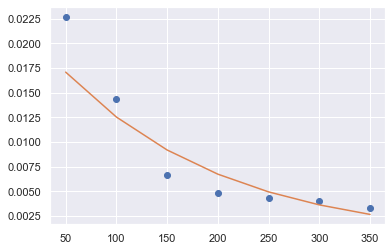

In [38]:
y_fit = np.exp(-3.76) * np.exp(-0.0062*x_data)
plt.plot(x_data, y_data, "o")
plt.plot(x_data, y_fit)

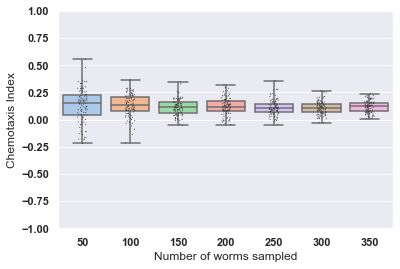

In [85]:
sns.set_theme(style="darkgrid")
sns.boxplot(x="N", y="CI", data=CI_df_long, whis=np.inf, palette="pastel")
sns.stripplot(x="N", y="CI", data=CI_df_long, size=1, color='.2')
plt.xlabel("Number of worms sampled")
plt.ylabel("Chemotaxis Index")
plt.ylim(-1,1)
plt.savefig('/Volumes/LaCie/_2021_03_screen/dmso_resample.png')

Text(0.5, 1.0, 'Variance of chemotaxis indices \nagainst sample size')

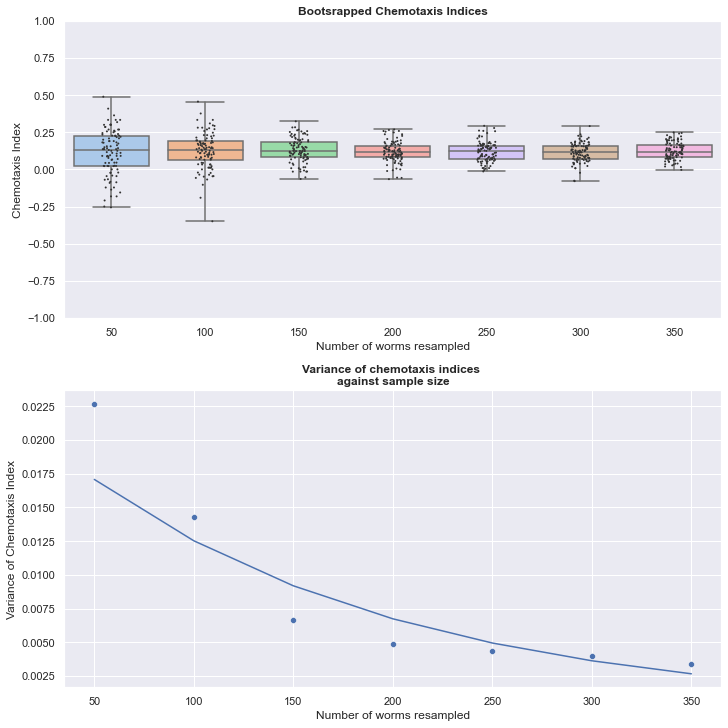

In [81]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), constrained_layout=True)
axes[0] = sns.boxplot(x="N", y="CI", data=CI_df_long, whis=np.inf, palette="pastel", ax=axes[0])
axes[0] = sns.stripplot(x="N", y="CI", data=CI_df_long, size=2, color='.2', ax=axes[0])
axes[0].set(xlabel="Number of worms resampled", ylabel="Chemotaxis Index", ylim=(-1,1))
axes[0].set_title('Bootsrapped Chemotaxis Indices', weight='bold')
#fig.delaxes(axes[1])

axes[1] = sns.scatterplot(x='N', y='CI', data=v, marker='o' ,ax=axes[1],  ci=None)
axes[1] = sns.lineplot(x=x_data, y=y_fit)
axes[1].set(xlabel = ("Number of worms resampled"), ylabel=("Variance of Chemotaxis Index"))
axes[1].set_title('Variance of chemotaxis indices \nagainst sample size', weight='bold')
